## Classification Modeling

In [1]:
%pylab inline
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

import random

%config InlineBackend.figure_formats = ['retina']

from collections import OrderedDict

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, r2_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix

import pickle 

Populating the interactive namespace from numpy and matplotlib


## Data Preparation

### Creating dataframe to fit on

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
with open("df_X.pkl", 'rb') as picklefile: 
    df_X = pickle.load(picklefile)

In [223]:
df_X

,code,nta,month,crime_date,day/night,crime_count,TotalPop,Men,Women,Income,pov_pop,unemp_pop,code_pov,code_unemp,crime_level,geometry,is_high
0,BK09,Brooklyn Heights-Cobble Hill,Jan,2016-01-01,day,1,2600,1296,1304,91964.00,189.80,205.40,7.30,7.90,Low,"POLYGON ((986367.735 190549.239, 985813.835 19...",0
1,BK09,Brooklyn Heights-Cobble Hill,Jan,2016-01-01,night,2,2600,1296,1304,91964.00,189.80,205.40,7.30,7.90,Low,"POLYGON ((986367.735 190549.239, 985813.835 19...",0
2,BK09,Brooklyn Heights-Cobble Hill,Jan,2016-01-03,day,1,2600,1296,1304,91964.00,189.80,205.40,7.30,7.90,Low,"POLYGON ((986367.735 190549.239, 985813.835 19...",0
3,BK09,Brooklyn Heights-Cobble Hill,Jan,2016-01-03,night,2,2600,1296,1304,91964.00,189.80,205.40,7.30,7.90,Low,"POLYGON ((986367.735 190549.239, 985813.835 19...",0
4,BK09,Brooklyn Heights-Cobble Hill,Jan,2016-01-04,day,1,2600,1296,1304,91964.00,189.80,205.40,7.30,7.90,Low,"POLYGON ((986367.735 190549.239, 985813.835 19...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228602,QN76,Baisley Park,Dec,2018-12-28,night,4,7120,3259,3861,60616.33,774.62,730.02,10.88,10.25,Low,"POLYGON ((1046740.336 187276.198, 1046724.788 ...",0
228603,QN76,Baisley Park,Dec,2018-12-29,day,2,7120,3259,3861,60616.33,774.62,730.02,10.88,10.25,Low,"POLYGON ((1046740.336 187276.198, 1046724.788 ...",0
228604,QN76,Baisley Park,Dec,2018-12-29,night,3,7120,3259,3861,60616.33,774.62,730.02,10.88,10.25,Low,"POLYGON ((1046740.336 187276.198, 1046724.788 ...",0
228605,QN76,Baisley Park,Dec,2018-12-30,day,1,7120,3259,3861,60616.33,774.62,730.02,10.88,10.25,Low,"POLYGON ((1046740.336 187276.198, 1046724.788 ...",0


In [5]:
df_X['is_high'] = df_X.crime_level.apply(lambda x: 1 if x == "High" else 0)

In [6]:
import datetime
df_X['month'] = df_X['month'].apply(lambda x : datetime.date(1900,x, 1).strftime('%b'))

In [7]:
X_baseline = df_X[['TotalPop','Men', 'Women','Income', 'code_pov', 'code_unemp']]
X = df_X[['code','month','day/night','TotalPop','Men', 'Women', 'Income', 'code_pov', 'code_unemp']]

y = df_X.is_high

### Pair plot

In [11]:
train_df = df_X[['TotalPop', 'Income', 'code_pov', 'code_unemp', 'is_high','crime_level']]

In [12]:
train_df.crime_level.value_counts()

Low     156614
High     71993
Name: crime_level, dtype: int64

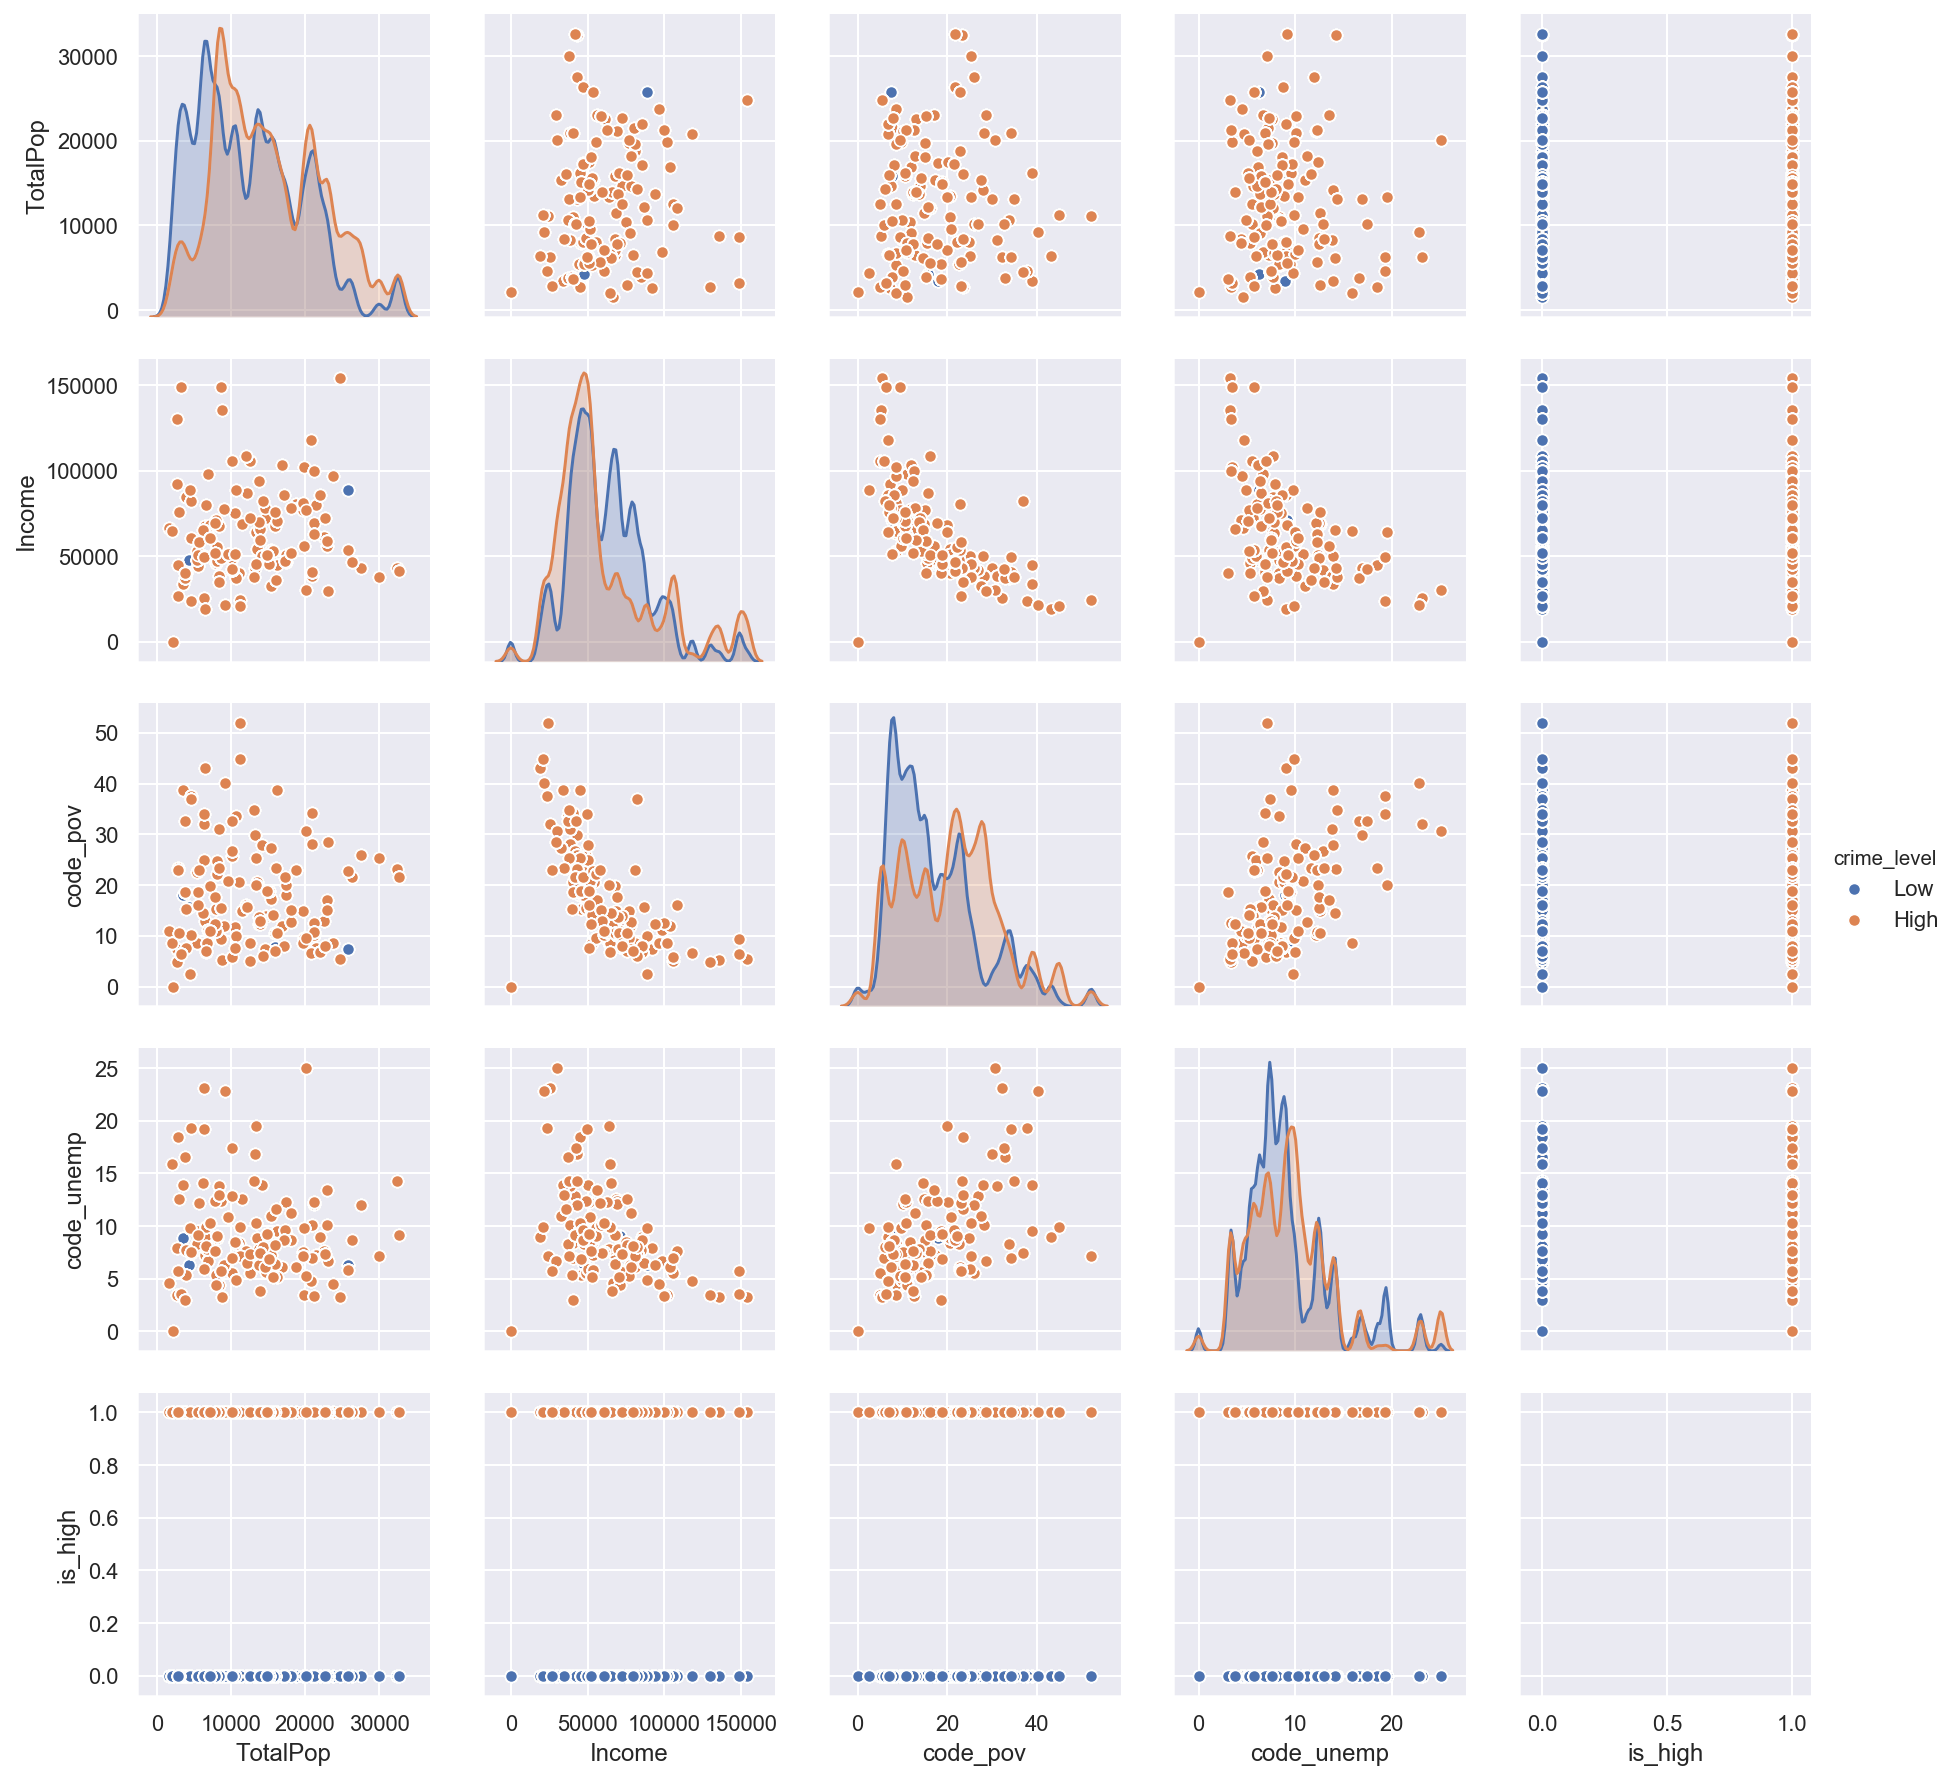

In [40]:
sns.pairplot(train_df, hue='crime_level')

## Logistic Regression

* Find C that makes the best score. Lower the C more regularizaiton (first compare the accuracy btw train and val)
* Move Probabability Threshold, since recall/F1 is lower. How?

### Baseline Model: demographics

In [255]:
X_train_val, X_test_b, y_train_val, y_test_b = train_test_split(X_baseline, y, test_size=0.2,random_state=42,stratify = y)
X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43, stratify = y_train_val)

In [256]:
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler()

X_train_b_sc = std_scale.fit_transform(X_train_b)
X_val_b_sc = std_scale.fit_transform(X_val_b)
X_test_b_sc = std_scale.fit_transform(X_test_b)

In [257]:
lr_b = LogisticRegression()
lr_b.fit(X_train_b_sc, y_train_b)

print('Accuracy:', accuracy_score(y_val_b, lr_b.predict(X_val_b_sc)))
print('Precision:', precision_score(y_val_b, lr_b.predict(X_val_b_sc)))
print('Recall:', recall_score(y_val_b, lr_b.predict(X_val_b_sc)))
print('F1:', f1_score(y_val_b, lr_b.predict(X_val_b_sc)))

Accuracy: 0.6941078692970561
Precision: 0.5444372713578652
Recall: 0.17570664629488159
F1: 0.26567258216948436


### Adding additional features: locations, month, day/night

In [258]:
X = pd.get_dummies(X, drop_first=True)
X

,TotalPop,Men,Women,Income,code_pov,code_unemp,code_BK17,code_BK19,code_BK21,code_BK23,code_BK25,code_BK26,code_BK28,code_BK29,code_BK30,code_BK31,code_BK32,code_BK33,code_BK34,code_BK35,code_BK37,code_BK38,code_BK41,code_BK42,code_BK43,code_BK44,code_BK45,code_BK46,code_BK50,code_BK58,code_BK60,code_BK61,code_BK63,code_BK68,code_BK69,code_BK72,code_BK73,code_BK75,code_BK76,code_BK77,code_BK78,code_BK79,code_BK81,code_BK82,code_BK83,code_BK85,code_BK88,code_BK90,code_BK91,code_BK95,code_BK96,code_MN01,code_MN03,code_MN04,code_MN06,code_MN09,code_MN11,code_MN12,code_MN13,code_MN14,code_MN15,code_MN17,code_MN19,code_MN20,code_MN22,code_MN23,code_MN24,code_MN25,code_MN27,code_MN28,code_MN31,code_MN32,code_MN33,code_MN34,code_MN35,code_MN36,code_MN40,code_MN50,code_QN01,code_QN02,code_QN03,code_QN05,code_QN06,code_QN07,code_QN08,code_QN10,code_QN12,code_QN15,code_QN17,code_QN18,code_QN19,code_QN20,code_QN21,code_QN22,code_QN23,code_QN25,code_QN27,code_QN28,code_QN29,code_QN30,code_QN31,code_QN33,code_QN34,code_QN35,code_QN37,code_QN38,code_QN41,code_QN42,code_QN43,code_QN44,code_QN45,code_QN46,code_QN47,code_QN48,code_QN49,code_QN50,code_QN51,code_QN52,code_QN53,code_QN54,code_QN55,code_QN56,code_QN57,code_QN60,code_QN61,code_QN62,code_QN63,code_QN66,code_QN68,code_QN70,code_QN71,code_QN72,code_QN76,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,day/night_night
0,2600,1296,1304,91964.00,7.30,7.90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,2600,1296,1304,91964.00,7.30,7.90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,2600,1296,1304,91964.00,7.30,7.90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,2600,1296,1304,91964.00,7.30,7.90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,2600,1296,1304,91964.00,7.30,7.90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228602,7120,3259,3861,60616.33,10.88,10.25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
228603,7120,3259,3861,60616.33,10.88,10.25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [259]:
# with additional features
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42,stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43, stratify = y_train_val)

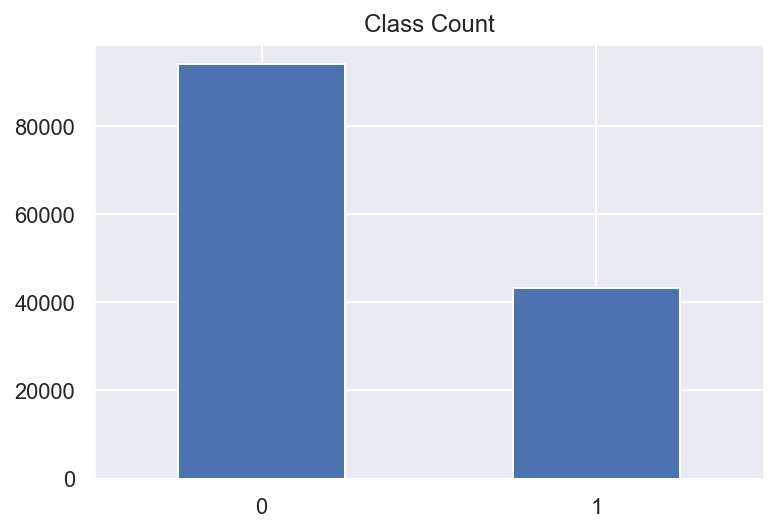

In [260]:
# Class Imbalance Check
y_train.value_counts().plot(kind='bar', title='Class Count', rot=0)

In [261]:
# Scale Features
X_train_scaled = std_scale.fit_transform(X_train)
X_val_scaled = std_scale.fit_transform(X_val)
X_test_scaled = std_scale.fit_transform(X_test)

In [262]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
# No overfitting. Very similar
print (f1_score(y_train, lr.predict(X_train_scaled)), f1_score(y_val, lr.predict(X_val_scaled)))

0.6732026977064395 0.6752318686331154


In [16]:
print('Accuracy:', accuracy_score(y_val, lr.predict(X_val_scaled)))
print('Precision:', precision_score(y_val, lr.predict(X_val_scaled)))
print('Recall:', recall_score(y_val, lr.predict(X_val_scaled)))
print('F1:', f1_score(y_val, lr.predict(X_val_scaled)))

Accuracy: 0.8131315340536285
Precision: 0.7458224871945588
Recall: 0.6168483922494618
F1: 0.6752318686331154


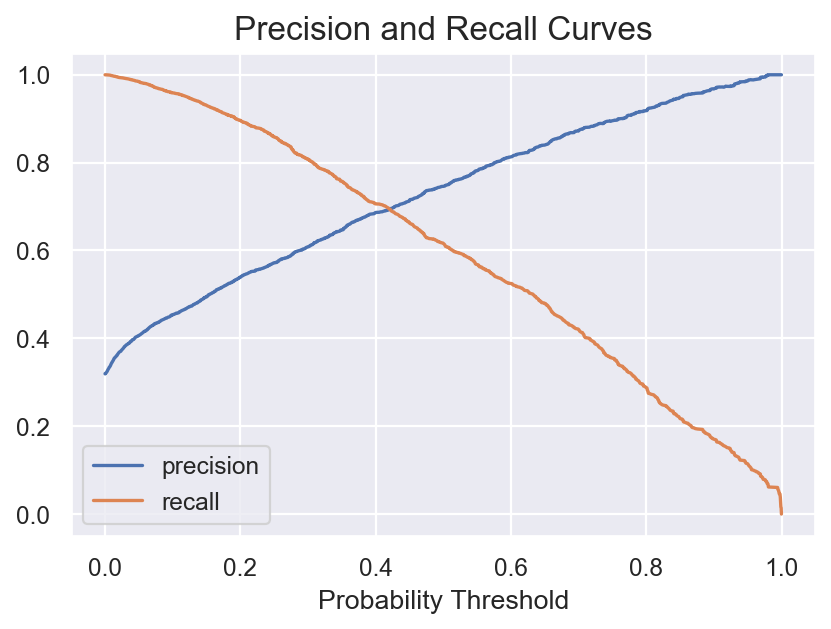

In [263]:
# Checking the best trade-off point between precision and recall
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, lr.predict_proba(X_val_scaled)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Probability Threshold');
plt.title('Precision and Recall Curves', fontsize = 15);

In [268]:
# changing proba threshold to improve Recall
prediction_soft = lr.predict_proba(X_val_scaled)[:,1] #DP [:,1] means probability of positive class
thres = 0.4
ypred_lr = prediction_soft>thres

In [269]:
print('Accuracy:', accuracy_score(y_val, ypred_lr))
print('Precision:', precision_score(y_val, ypred_lr))
print('Recall:', recall_score(y_val, ypred_lr))
print('F1:', f1_score(y_val, ypred_lr))

Accuracy: 0.8057609028476445
Precision: 0.6861673414304993
Recall: 0.7062295992777277
F1: 0.6960539375064171


In [270]:
prediction_hard = lr.predict(X_train_scaled)
confusion_matrix(y_train, prediction_hard)

array([[85128,  8840],
       [16793, 26402]])

In [271]:
def make_confusion_matrix(model, X, y, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y, y_predict)
    plt.figure(dpi=90)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Low', 'High'],
           yticklabels=['Low', 'High']);
    plt.xlabel('Prediction')
    plt.ylabel('Actual')

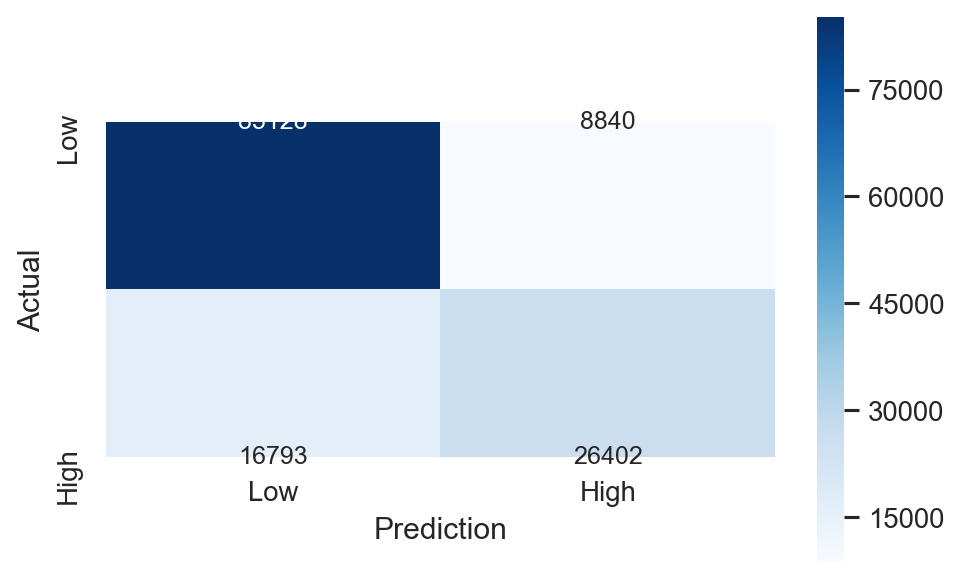

In [272]:
make_confusion_matrix(lr, X_train_scaled, y_train, threshold = 0.5)

In [362]:
coef_df = pd.DataFrame(lr.coef_)
coef_df.columns = X_train.columns
coef_df = coef_df.transpose().sort_values(by = 0).reset_index()
coef_df = coef_df.drop(range(5,134))
coef_df['index'] = coef_df['index'].apply(lambda x : x.strip('code_'))
coef_df.loc[3,'index'] = 'night'
coef_df.columns = ['coef', 'coef_values']
coef_df = coef_df.merge(df_X[['code', 'nta']], how = 'left', left_on = 'coef', right_on = 'code')
coef_df.drop_duplicates(inplace = True)
coef_df.loc[[2377,2955, 2956,2957,16259],'nta'] = ['Night', 'Men', ' Total Pop', 'Women','Poverty Rate']  
coef_df

,coef,coef_values,code,nta
0,QN45,-0.54,QN45,Douglas Manor-Douglaston-Little Neck
748,QN42,-0.53,QN42,Oakland Gardens
1609,QN47,-0.47,QN47,Ft. Totten-Bay Terrace-Clearview
2377,night,-0.42,NaN,Night
2378,BK46,-0.37,BK46,Ocean Parkway South
2955,Men,0.36,NaN,Men
2956,TotalPop,0.37,NaN,Total Pop
2957,Women,0.37,NaN,Women
2958,MN22,0.38,MN22,East Village
5181,BK81,0.41,BK81,Brownsville


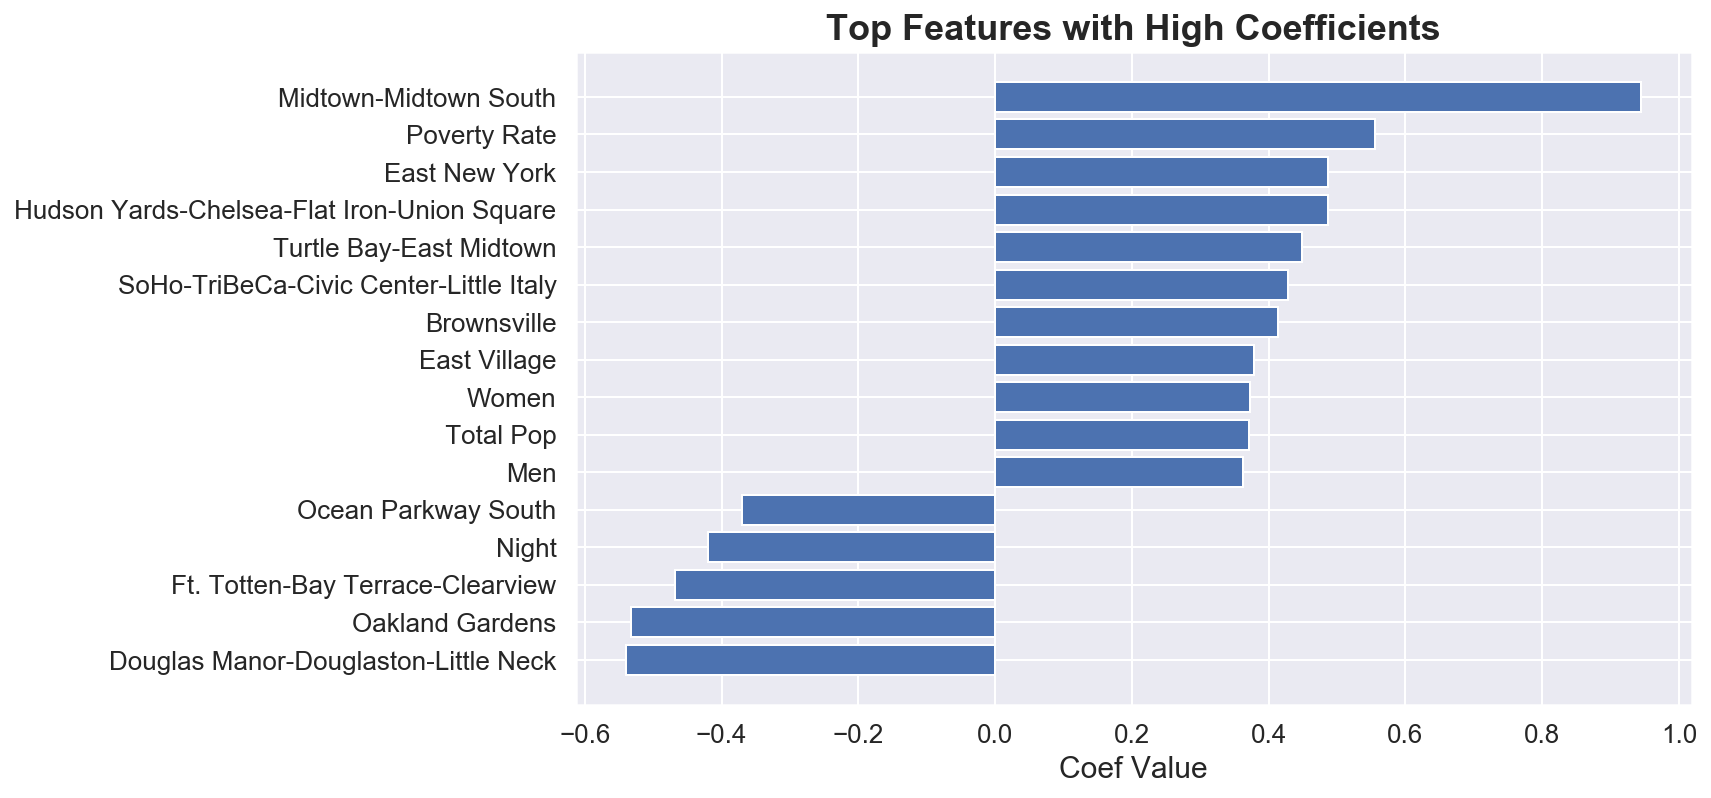

In [364]:
plt.figure(figsize = [10,6])
plt.barh(coef_df['nta'],coef_df['coef_values'])

plt.xlabel('Coef Value', fontsize = 15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title('Top Features with High Coefficients', fontsize = 18, fontweight = 'bold');

In [299]:
sorted(list(zip(X_train.columns,lr.coef_[0])), key = (lambda x: x[1]))

[('code_QN45', -0.5395884977577106),
 ('code_QN42', -0.5330122463965341),
 ('code_QN47', -0.4678335232840592),
 ('day/night_night', -0.4196012769806126),
 ('code_BK46', -0.3700324351070205),
 ('code_QN27', -0.3329521399072963),
 ('code_QN35', -0.27691306063768767),
 ('code_QN38', -0.23304141955551164),
 ('code_QN12', -0.22886486733488998),
 ('code_QN51', -0.21216487284839194),
 ('code_BK41', -0.21052822260142612),
 ('code_QN62', -0.20660680668676934),
 ('code_QN49', -0.20422953464426616),
 ('code_QN44', -0.1974719136085239),
 ('Income', -0.19463087195000492),
 ('code_QN41', -0.19211516085965877),
 ('code_QN23', -0.18403056871275392),
 ('code_QN57', -0.18336888135081142),
 ('code_QN48', -0.17332299704211293),
 ('code_BK90', -0.16238322160942464),
 ('code_QN06', -0.16003096232601896),
 ('code_QN15', -0.15936020004149193),
 ('code_QN56', -0.1592633101910168),
 ('code_QN43', -0.15323052561921732),
 ('code_MN35', -0.14439362649998239),
 ('code_MN20', -0.1443169240542374),
 ('code_QN60', -0.

### Adding weather features

* Did not adding any values

In [103]:
X_w = pd.get_dummies(X_w, drop_first=True)

In [104]:
# with weather features
X_train_val, X_test_w, y_train_val, y_test_w = train_test_split(X_w, y, test_size=0.2,random_state=42,stratify = y)
X_train_w, X_val_w, y_train_w, y_val_w = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43, stratify = y_train_val)

In [71]:
X_train_w_sc = std_scale.fit_transform(X_train_w)
X_val_w_sc = std_scale.fit_transform(X_val_w)
X_test_w_sc = std_scale.fit_transform(X_test_w)

In [72]:
lr_w = LogisticRegression()
lr_w.fit(X_train_w_sc, y_train_w)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [73]:
print('Accuracy:', accuracy_score(y_val_w, lr_w.predict(X_val_w_sc)))
print('Precision:', precision_score(y_val_w, lr_w.predict(X_val_w_sc)))
print('Recall:', recall_score(y_val_w, lr_w.predict(X_val_w_sc)))
print('F1:', f1_score(y_val_w, lr_w.predict(X_val_w_sc)))

Accuracy: 0.8129346922706793
Precision: 0.7467083051991897
Recall: 0.6144176678936037
F1: 0.6741341867642017


In [74]:
prediction_soft = lr_w.predict_proba(X_val_w_sc)[:,1] #DP [:,1] means probability of positive class
thres = 0.35
ypred = prediction_soft>thres

In [75]:
print('Accuracy:', accuracy_score(y_val_w, ypred))
print('Precision:', precision_score(y_val_w, ypred))
print('Recall:', recall_score(y_val_w, ypred))
print('F1:', f1_score(y_val_w, ypred))

Accuracy: 0.7955032588250732
Precision: 0.6515215173158874
Recall: 0.7538717966525453
F1: 0.6989697359948487


## KNN

* Very low recall rate. Maybe because it is not a good model with diverse features (continuous and categorical) not good with too many features
* What is good number for K? Higher the K, more biased, lower the K, more complex high variance
* Model build takes long n^2*f 
* don't scale features

In [50]:
knn = KNeighborsClassifier(n_neighbors=5) # what is the good approx K?
knn.fit(X_train, y_train) # don't scale features

print('Accuracy:', accuracy_score(y_val, knn.predict(X_val)))
print('Precision:', precision_score(y_val, knn.predict(X_val)))
print('Recall:', recall_score(y_val, knn.predict(X_val)))
print('F1:', f1_score(y_val, knn.predict(X_val)))

Accuracy: 0.791960106731989
Precision: 0.6899044066215901
Recall: 0.6165011459129106
F1: 0.6511406146849557


## Gaussian Naive Bayes

* Very low recall rates, maybe because it is not good with non-homogenous features
* Can naive bayes handle continuous values? Also, 
* Don't scale features, it will change the decision

In [21]:
gnb = GaussianNB()
gnb.fit(X_train, y_train) 

print('Accuracy:', accuracy_score(y_val, gnb.predict(X_val)))
print('Precision:', precision_score(y_val, gnb.predict(X_val)))
print('Recall:', recall_score(y_val, gnb.predict(X_val)))
print('F1:', f1_score(y_val, gnb.predict(X_val)))


Accuracy: 0.7057871484187044
Precision: 0.5515514425694067
Recall: 0.35182998819362454
F1: 0.4296132971506106


In [220]:
confusion_matrix(y_train, gnb.predict(X_train))

array([[81314, 12654],
       [28216, 14979]])

## Decision Trees

* To overcome overfitting.. control max_depth, min_samples_leaf

In [22]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train) 

print('Accuracy:', accuracy_score(y_val, dtc.predict(X_val)))
print('Precision:', precision_score(y_val, dtc.predict(X_val)))
print('Recall:', recall_score(y_val, dtc.predict(X_val)))
print('F1:', f1_score(y_val, dtc.predict(X_val)))

Accuracy: 0.8141813568960238
Precision: 0.7607101846126667
Recall: 0.5980970900756997
F1: 0.6696734059097977


In [55]:
print (f1_score(y_train, dtc.predict(X_train)), f1_score(y_val, dtc.predict(X_val)))

0.6792267026018451 0.6696734059097977


In [23]:
# changing proba threshold to improve Recall
prediction_soft = dtc.predict_proba(X_val)[:,1] #DP [:,1] means probability of positive class
thres = 0.35
ypred = prediction_soft>thres

In [24]:
print('Accuracy:', accuracy_score(y_val, ypred))
print('Precision:', precision_score(y_val, ypred))
print('Recall:', recall_score(y_val,ypred))
print('F1:', f1_score(y_val, ypred))

Accuracy: 0.7917851362582564
Precision: 0.6431211498973306
Recall: 0.7613028682547399
F1: 0.6972395369545858


In [111]:
list(zip(X_train.columns,dtc.feature_importances_))

[('TotalPop', 0.2689901195173585),
 ('Income', 0.13151750149807714),
 ('code_pov', 0.198089432009519),
 ('code_unemp', 0.03722221072609575),
 ('code_BK17', 2.01008773961883e-05),
 ('code_BK19', 4.902092553867292e-05),
 ('code_BK21', 0.0),
 ('code_BK23', 2.010821135703044e-06),
 ('code_BK25', 0.0),
 ('code_BK26', 1.5837568680067935e-05),
 ('code_BK28', 2.1290604509476023e-05),
 ('code_BK29', 1.9500784843490907e-05),
 ('code_BK30', 1.999925287092176e-05),
 ('code_BK31', 0.0),
 ('code_BK32', 0.0),
 ('code_BK33', 0.0001048179537333328),
 ('code_BK34', 0.005126684795933739),
 ('code_BK35', 5.599481944996633e-05),
 ('code_BK37', 3.7178051652484388e-06),
 ('code_BK38', 3.897424119439461e-05),
 ('code_BK41', 0.0),
 ('code_BK42', 0.010081036571222083),
 ('code_BK43', 1.1718297530550709e-06),
 ('code_BK44', 0.0),
 ('code_BK45', 0.0009015047311211017),
 ('code_BK46', 0.0),
 ('code_BK50', 0.018926074344570432),
 ('code_BK58', 7.726317674947907e-06),
 ('code_BK60', 0.00019180565528758024),
 ('code_

## Random Forest

* Random Forest overcome the overfitting of decision trees by ensambling

In [25]:
# Takes some time to fit the model

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train) 

print('Accuracy:', accuracy_score(y_val, rfc.predict(X_val)))
print('Precision:', precision_score(y_val, rfc.predict(X_val)))
print('Recall:', recall_score(y_val, rfc.predict(X_val)))
print('F1:', f1_score(y_val, rfc.predict(X_val)))

Accuracy: 0.8141376142775907
Precision: 0.7577080967770111
Recall: 0.6024723939162442
F1: 0.6712318167749923


In [52]:
print (accuracy_score(y_train, rfc.predict(X_train)), accuracy_score(y_val, rfc.predict(X_val)))

0.8194994276882249 0.8141376142775907


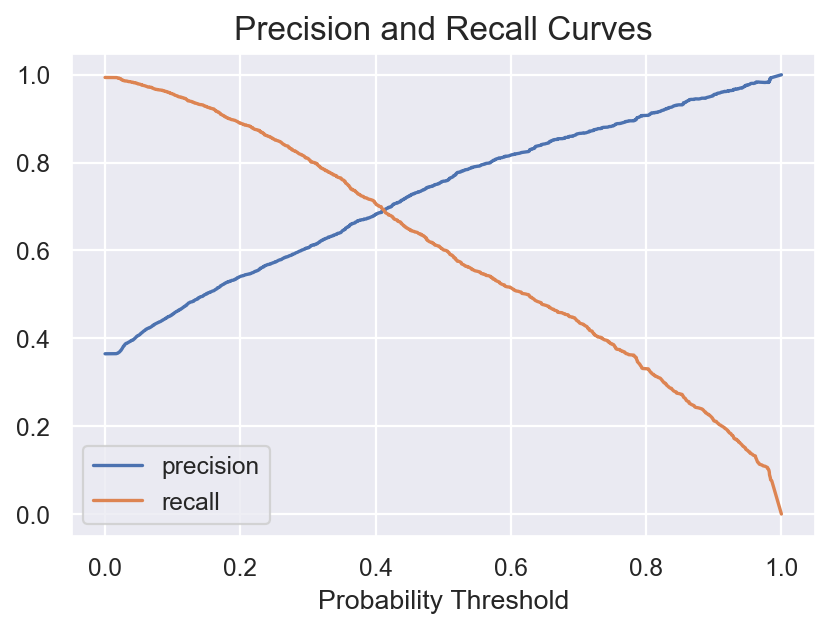

In [224]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, rfc.predict_proba(X_val)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Probability Threshold');
plt.title('Precision and Recall Curves', fontsize = 15);

In [147]:
# changing proba threshold to improve Recall
prediction_soft = rfc.predict_proba(X_val)[:,1] #DP [:,1] means probability of positive class
thres = 0.4
ypred = prediction_soft>thres

In [148]:
print('Accuracy:', accuracy_score(y_val, ypred))
print('Precision:', precision_score(y_val, ypred))
print('Recall:', recall_score(y_val,ypred))
print('F1:', f1_score(y_val, ypred))

Accuracy: 0.803901841564236
Precision: 0.6817664770826364
Recall: 0.7076185846239322
F1: 0.6944520174482007


## Scoring Summary

In [333]:
scoring_data = ({"Logistic Reg." : [accuracy_score(y_val, lr.predict(X_val_scaled)),
                                          precision_score(y_val, lr.predict(X_val_scaled)),
                                          recall_score(y_val, lr.predict(X_val_scaled)),
                                          f1_score(y_val, lr.predict(X_val_scaled))],
                 "KNN":[accuracy_score(y_val, knn.predict(X_val)),
                        precision_score(y_val, knn.predict(X_val)),
                        recall_score(y_val, knn.predict(X_val)),
                        f1_score(y_val, knn.predict(X_val))],
                 "Gaussian NB": [accuracy_score(y_val, gnb.predict(X_val)),
                                 precision_score(y_val, gnb.predict(X_val)),
                                 recall_score(y_val, gnb.predict(X_val)),
                                 f1_score(y_val, gnb.predict(X_val))],
                 "Decision Tree": [accuracy_score(y_val, dtc.predict(X_val)),
                                   precision_score(y_val, dtc.predict(X_val)),
                                   recall_score(y_val, dtc.predict(X_val)),
                                   f1_score(y_val, dtc.predict(X_val))],
                 "Random Forest":[accuracy_score(y_val, rfc.predict(X_val)),
                                  precision_score(y_val, rfc.predict(X_val)),
                                  recall_score(y_val, rfc.predict(X_val)),
                                  f1_score(y_val, rfc.predict(X_val))]})
                
scoring_df = pd.DataFrame(scoring_data, index = ["Accuracy","Precision","Recall","F1"])

In [334]:
scoring_df

,Logistic Reg.,KNN,Gaussian NB,Decision Tree,Random Forest
Accuracy,0.81,0.79,0.71,0.81,0.81
Precision,0.75,0.69,0.55,0.76,0.76
Recall,0.62,0.62,0.35,0.60,0.60
F1,0.68,0.65,0.43,0.67,0.67


In [249]:
auc_df
# simpler / interpretability

,AUC
Logistic Regression,0.88
KNN,0.83
Gaussian NB,0.67
Decision Tree,0.87
Random Forest,0.87


## ROC Curve / AUC

In [30]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr1, tpr1, thresholds1 = roc_curve(y_val, lr.predict_proba(X_val_scaled)[:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_val, knn.predict_proba(X_val)[:,1])
fpr3, tpr3, thresholds3 = roc_curve(y_val, gnb.predict_proba(X_val)[:,1])
fpr4, tpr4, thresholds4 = roc_curve(y_val, dtc.predict_proba(X_val)[:,1])
fpr5, tpr5, thresholds5 = roc_curve(y_val, rfc.predict_proba(X_val)[:,1])

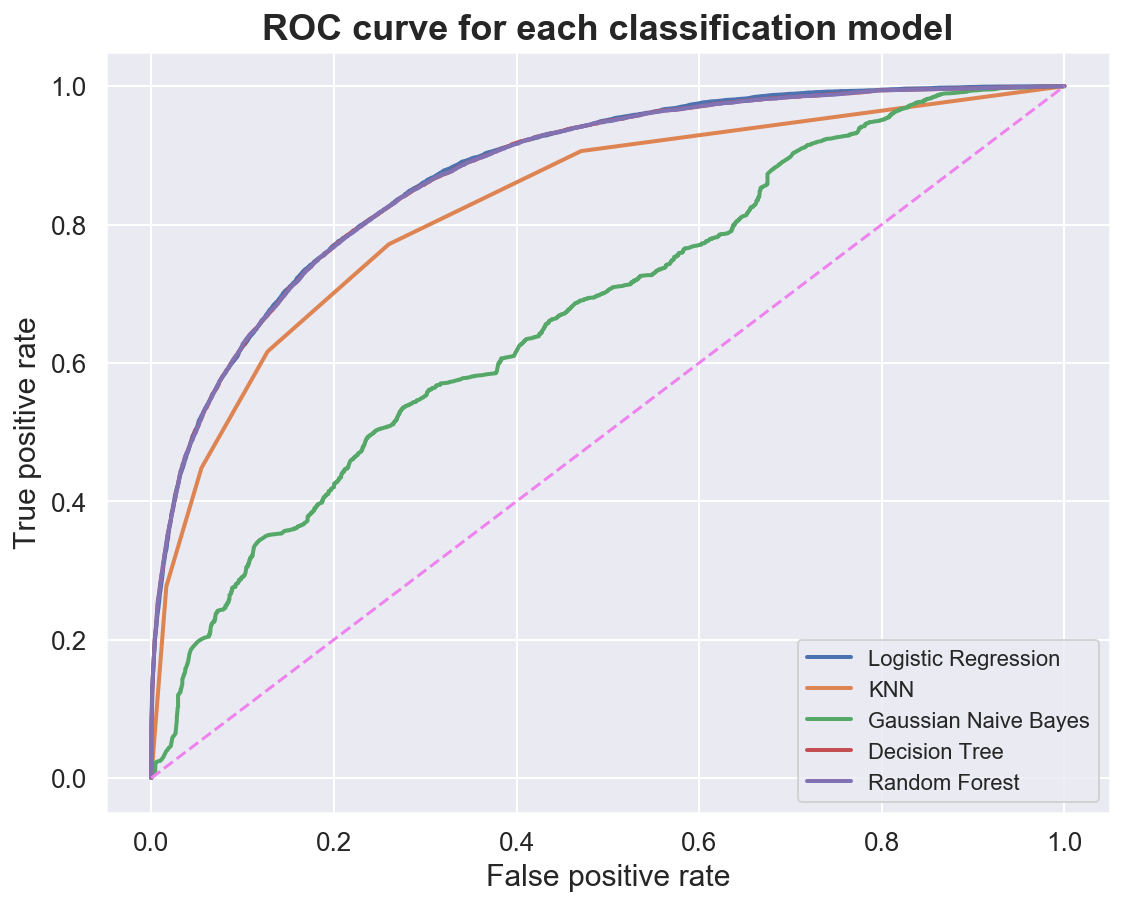

In [340]:
plt.figure(figsize = [9,7])
plt.plot(fpr1, tpr1,lw=2, label = "Logistic Regression")
plt.plot(fpr2, tpr2,lw=2, label = "KNN")
plt.plot(fpr3, tpr3,lw=2, label = "Gaussian Naive Bayes")
plt.plot(fpr4, tpr4,lw=2, label = "Decision Tree")
plt.plot(fpr5, tpr5,lw=2, label = "Random Forest")

plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend(loc = 4)

plt.xlabel('False positive rate', fontsize = 15)
plt.ylabel('True positive rate', fontsize = 15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title('ROC curve for each classification model', fontsize = 18, fontweight = 'bold');


In [248]:
auc_data = ({'AUC': [roc_auc_score(y_val, lr.predict_proba(X_val_scaled)[:,1]), 
                     roc_auc_score(y_val, knn.predict_proba(X_val)[:,1]),
                     roc_auc_score(y_val, gnb.predict_proba(X_val)[:,1]),
                     roc_auc_score(y_val, dtc.predict_proba(X_val)[:,1]),
                     roc_auc_score(y_val, rfc.predict_proba(X_val)[:,1])]})

auc_df = pd.DataFrame(auc_data, index=['Logistic Regression', 'KNN', 'Gaussian NB', 'Decision Tree', 'Random Forest' ])
auc_df

,AUC
Logistic Regression,0.88
KNN,0.83
Gaussian NB,0.67
Decision Tree,0.87
Random Forest,0.87


## Predict with test data

### Predict with X_test and residual

In [273]:
prediction_soft = lr.predict_proba(X_test_scaled)[:,1] #DP [:,1] means probability of positive class
thres = 0.40
y_pred = prediction_soft>thres

In [275]:
res_df = pd.merge(y_test, df_X, how = 'left', left_index = True, right_index = True)
res_df['predict_proba'] = prediction_soft
del res_df['is_high_x']
res_df['res'] = res_df['is_high_y']-res_df['predict_proba']
res_df.sort_values(by='res', ascending=False)

,code,nta,month,crime_date,day/night,crime_count,TotalPop,Men,Women,Income,pov_pop,unemp_pop,code_pov,code_unemp,crime_level,geometry,is_high_y,predict_proba,res
192588,QN42,Oakland Gardens,Nov,2016-11-17,day,6,20143,9258,10885,77093.75,1918.72,1054.95,9.53,5.24,High,"POLYGON ((1056254.319 208432.264, 1055902.161 ...",1,0.00,1.00
199047,QN49,Whitestone,Feb,2017-02-12,night,5,15893,8272,7621,75708.75,1109.20,1295.76,6.98,8.15,High,"POLYGON ((1041904.434 226927.508, 1041968.085 ...",1,0.00,1.00
189965,QN38,Pomonok-Flushing Heights-Hillcrest,Jan,2017-01-24,night,5,10155,4763,5392,42739.50,3314.20,1766.87,32.64,17.40,High,"POLYGON ((1040671.302 208318.344, 1040674.718 ...",1,0.00,1.00
216482,QN62,Queensboro Hill,Sep,2016-09-19,day,5,5523,2815,2708,50947.00,883.68,502.59,16.00,9.10,High,"POLYGON ((1035407.183 211562.349, 1035574.302 ...",1,0.00,1.00
191145,QN41,Fresh Meadows-Utopia,Mar,2018-03-19,night,8,13692,6713,6979,70064.00,1873.41,1071.00,13.68,7.82,High,"POLYGON ((1045896.171 205383.934, 1045643.832 ...",1,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60623,BK75,Bedford,Apr,2016-04-03,day,4,16230,8580,7650,45177.50,6291.85,1551.74,38.77,9.56,Low,"POLYGON ((1000351.303 194574.900, 999670.074 1...",0,0.97,-0.97
61573,BK75,Bedford,Sep,2016-09-19,day,4,16230,8580,7650,45177.50,6291.85,1551.74,38.77,9.56,Low,"POLYGON ((1000351.303 194574.900, 999670.074 1...",0,0.98,-0.98
61685,BK75,Bedford,Sep,2018-09-15,day,4,16230,8580,7650,45177.50,6291.85,1551.74,38.77,9.56,Low,"POLYGON ((1000351.303 194574.900, 999670.074 1...",0,0.98,-0.98
61583,BK75,Bedford,Sep,2016-09-24,day,4,16230,8580,7650,45177.50,6291.85,1551.74,38.77,9.56,Low,"POLYGON ((1000351.303 194574.900, 999670.074 1...",0,0.98,-0.98


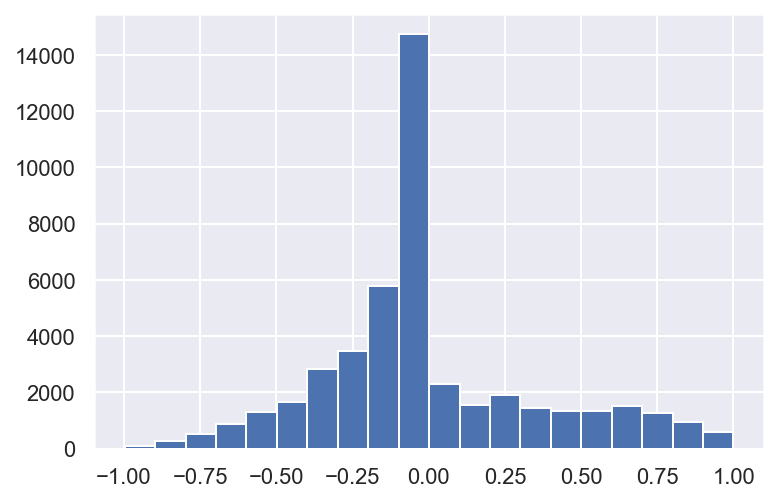

In [276]:
# residuals are normally distributed

plt.hist(res_df['res'], bins = 20);

In [278]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test,y_pred))
print('F1:', f1_score(y_test, y_pred))

Accuracy: 0.8038799702550194
Precision: 0.6843105320304017
Recall: 0.7003264115563581
F1: 0.6922258452033637


### Predicting crime occurance in NY

In [279]:
df_2018 = df_X[(df_X['crime_date'].dt.year == 2018)]

In [280]:
X_2018 = df_val[['code','month','day/night','TotalPop','Men', 'Women', 'Income', 'code_pov', 'code_unemp']]
y_2018 = df_val.crime_level

In [281]:
X_2018 = pd.get_dummies(X_valen, drop_first=True)

In [282]:
X_2018_scaled = std_scale.fit_transform(X_2018)

In [283]:
prediction_soft = lr.predict_proba(X_2018_scaled)[:,1]
thres = 0.4

In [284]:
y_pred = prediction_soft>thres
#map_dict = {False : 'Low', True: 'High'}
#y_pred = y_pred.map(map_dict)

In [285]:
df_2018['predict_proba'] = prediction_soft

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [286]:
df_2018['crime_level_pred'] = y_pred

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [287]:
df_2018['crime_level_pred']= df_2018['crime_level_pred'].map({False: 'Low', True: 'High'})
df_2018['crime_date'] = df_2018['crime_date'].apply(lambda x: x.strftime("%m-%d"))
df_2018[(df_2018['nta'] == 'Midtown-Midtown South')&(df_2018.crime_date == '02-14')]

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,code,nta,month,crime_date,day/night,crime_count,TotalPop,Men,Women,Income,pov_pop,unemp_pop,code_pov,code_unemp,crime_level,geometry,is_high,predict_proba,crime_level_pred
108938,MN17,Midtown-Midtown South,Feb,02-14,day,45,10591,4914,5677,88490.25,1044.32,515.27,9.86,4.87,High,"POLYGON ((991725.244 217725.299, 992169.505 21...",1,1.00,High
108939,MN17,Midtown-Midtown South,Feb,02-14,night,17,10591,4914,5677,88490.25,1044.32,515.27,9.86,4.87,High,"POLYGON ((991725.244 217725.299, 992169.505 21...",1,1.00,High


In [184]:
del df_2018['geometry']
df_2018.to_csv('df_2019.csv')